# SegNet Implementation

In [49]:
import tensorflow
import h5py
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [99]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Model, Sequential
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, UpSampling2D, Dropout, Cropping2D,Convolution2D
from keras.layers import BatchNormalization, Reshape, Layer
from keras.layers import Activation, Flatten, Dense
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.metrics import categorical_accuracy
from keras import backend as K
from keras import losses
from keras.models import load_model

In [51]:
hf = h5py.File('/home/joseph/Documents/data/Segmentation/HDF5/database_64_50.hdf5', 'r')

In [52]:
list(hf.keys())

['test_img', 'test_label', 'train_img', 'train_label', 'val_img', 'val_label']

In [53]:
train = hf['train_img'][:]
train = np.stack([train,train,train],axis=-1)

In [96]:
no_images, height, width, channels = train.shape

In [97]:
label = hf['train_label'][:]

In [98]:
train = train.reshape(-1,height,width,channels)

In [57]:
train.shape

(443, 64, 64, 3)

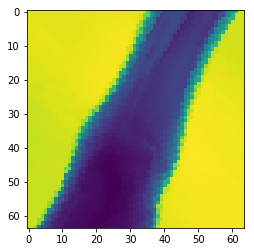

In [82]:
plt.imshow(train[0,...,0])

In [59]:
label = label.reshape((-1,64*64,3))

In [60]:
label.shape

(443, 4096, 3)

In [84]:
input_shape=(64, 64, 3)
classes=3

# c.f. https://github.com/alexgkendall/SegNet-Tutorial/blob/master/Example_Models/bayesian_segnet_camvid.prototxt
img_input = Input(shape=input_shape)
x = img_input
# Encoder
x = Conv2D(64, (3, 3), padding="same")(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(128, (3, 3), padding="same")(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(256, (3, 3), padding="same")(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(512, (3, 3), padding="same")(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)

# Decoder
x = Conv2D(512, (3, 3), padding="same")(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)

x = UpSampling2D(size=(2, 2))(x)
x = Conv2D(256, (3, 3), padding="same")(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)

x = UpSampling2D(size=(2, 2))(x)
x = Conv2D(128, (3, 3), padding="same")(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)

x = UpSampling2D(size=(2, 2))(x)
x = Conv2D(128, (3, 3), padding="same")(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)

x = Convolution2D(classes, (1,1), padding="valid")(x)


x = Reshape((input_shape[0]*input_shape[1],classes))(x)
x = Activation("softmax")(x)

model = Model(img_input, x)


In [85]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adadelta', metrics=["accuracy"])

In [86]:
model.fit(train,label,epochs = 20, batch_size = 10)

Epoch 1/20
443/443 [==============================] - 55s 124ms/step - loss: 0.7909 - acc: 0.6287
Epoch 2/20
443/443 [==============================] - 52s 118ms/step - loss: 0.6634 - acc: 0.6909
Epoch 3/20
443/443 [==============================] - 50s 112ms/step - loss: 0.6035 - acc: 0.7239
Epoch 4/20
443/443 [==============================] - 50s 112ms/step - loss: 0.5863 - acc: 0.7335
Epoch 5/20
443/443 [==============================] - 50s 113ms/step - loss: 0.5567 - acc: 0.7456
Epoch 6/20
443/443 [==============================] - 50s 113ms/step - loss: 0.5506 - acc: 0.7491
Epoch 7/20
443/443 [==============================] - 50s 113ms/step - loss: 0.5308 - acc: 0.7582
Epoch 8/20
443/443 [==============================] - 50s 113ms/step - loss: 0.5146 - acc: 0.7668
Epoch 9/20
443/443 [==============================] - 52s 118ms/step - loss: 0.4993 - acc: 0.7738
Epoch 10/20
443/443 [==============================] - 50s 113ms/step - loss: 0.4865 - acc: 0.7826
Epoch 11/20
443/443

In [100]:
model.save('SegNet.h5')  # creates a HDF5 file 'my_model.h5'
del model  # deletes the existing model

# returns a compiled model
# identical to the previous one
model = load_model('SegNet.h5')

In [88]:
test = hf['test_img'][:]
test = np.stack([test,test,test],axis=-1)

In [89]:
test = test.reshape(-1,64,64,3)

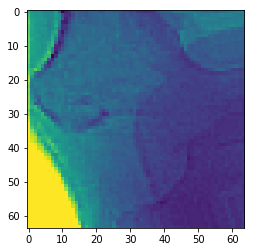

In [90]:
plt.imshow(test[1,...,0])

In [91]:
test[1].shape
test0 = test[1]
64*64
test0.shape

(64, 64, 3)

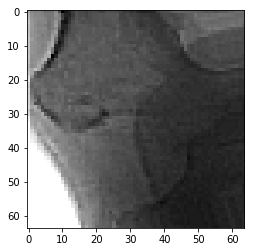

In [92]:
plt.imshow(test0)

In [93]:
test0 = test0.reshape((1,64,64,3))

In [101]:
prediction = model.predict(test0)
prediction = prediction.reshape((64,64,3))

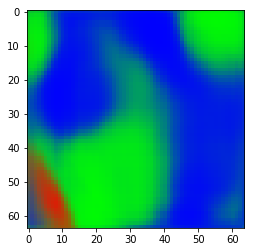

In [102]:
plt.imshow(prediction)

In [106]:
test_label = hf['test_label'][:]

In [107]:
test_label = test_label.reshape((-1,64*64,3))

In [108]:
model.evaluate(test,test_label)

95/95 [==============================] - 4s 38ms/step


[0.8186612173130637, 0.6568744954309965]